In [1]:
import time
import numpy as np
import numpy.linalg as nl
import scipy.linalg as sl
import scipy.special as ss
import scipy.optimize as so
import scipy.integrate as si
import matplotlib.pyplot as plt
from jax.config import config
import jax
import jax.numpy as jnp
import jax.numpy.linalg as jnl
config.update("jax_enable_x64", True)

<h1>TDSE Forward Problem</h1>

In [2]:
# size of spatial domain
L = 15.0

# number of real space grid points (for plotting)
numx = 1025

# real space grid points (for plotting)
xvec = np.linspace(-L, L, numx)

# number of Fourier basis functions
numfour = 32  # 64

# number of Toeplitz elements in the Fourier representation
numtoepelms = 2 * numfour + 1

# set number of time steps
# trajectory's length = numts + 1
numts = 20  # 20

# set time-step size
dt = 1e-2  # 1e-2

# print computational environment variables to stdout
print('L =', L)
print('numx =', numx)
print('numfour =', numfour)
print('numts =', numts)
print('dt =', dt)

L = 15.0
numx = 1025
numfour = 32
numts = 20
dt = 0.01


In [3]:
# vector of Fourier mode indices
# fournvec = -numfour,...,0,...,numfour
fournvec = np.arange(-numfour, numfour + 1)

# matrix for converting Fourier representation to real space
# used like realspacevec = fourspacevec @ fourtox
fourtox = np.exp(1j * np.pi * np.outer(fournvec, xvec) / L) / np.sqrt(2 * L)

---
**Potential Function**

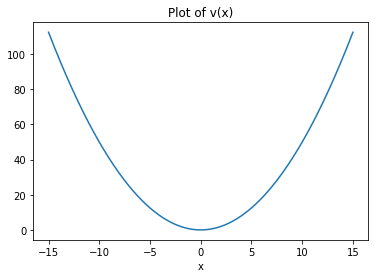

In [4]:
# define potential for generating training data

def v(z):
    # harmonic oscillator potential (should be exact for Chebyshev)
    return 0.5 * z**2

    # symmetric double well potential
    # return 2.5e-3 * (z ** 2 - 25) ** 2

    # asymmetric double well potential
    c0 = 4.35
    c1 = 9.40e-1
    c2 = -3.56e-1
    c3 = -4.66e-2
    c4 = 1.46e-2
    c5 = 6.76e-4
    c6 = -1.26e-4
    c7 = -5.43e-6
    c8 = 4.12e-7
    c9 = 1.65e-8
    x = z + 0.8
    return 0.5 * (c0 + c1 * x + c2 * x ** 2 + c3 * x ** 3 + c4 * x ** 4 + c5 * x ** 5 + c6 * x ** 6 + c7 * x ** 7 + c8 * x ** 8 + c9 * x ** 9)

    # soft coulomb potential
    # return -1 / np.sqrt(x**2 + 0.25)

# true potential on real space grid (for plotting)
vtruexvec = v(xvec)

# plot true potential
plt.plot(xvec, vtruexvec)
plt.title('Plot of v(x)')
plt.xlabel('x')
plt.show()

# compute the potential operator matrix, vmat
vtruetoep = []
for thisfourn in range(numtoepelms):
    def intgrnd(x):
        return v(x) * np.exp(-1j * np.pi * thisfourn * x / L) / (2 * L)
    def rintgrnd(x):
        return intgrnd(x).real
    def iintgrnd(x):
        return intgrnd(x).imag
    vtruetoep.append(si.quad(rintgrnd, -L, L, limit=100)[0] + 1j * si.quad(iintgrnd, -L, L, limit=100)[0])

vtruetoep = jnp.array(vtruetoep)
vtruemat = sl.toeplitz(r=vtruetoep, c=np.conj(vtruetoep))

---
**Initial States - a0**

Number of a0 states: 1


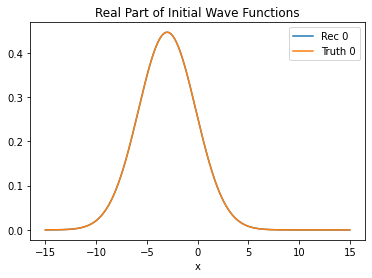

L2 Error of reconstructed psi0:
7.476210590807997e-05
L-infinity Error psi0:
3.137317008559103e-05


In [7]:
# define initial state functions
def psi0_0(x):
    return 10 * np.exp(-((x + 3) / 4)**2) * (2.0 / np.pi)**0.25
    # return 10 * np.exp(-((x + 3) / 2)**2) * (2.0 / np.pi)**0.25

def psi0_1(x):
    return np.exp(-((x - 3) / 4)**2) * (2.0 / np.pi)**0.25
    # return np.exp(-((x - 3) / 2)**2) * (2.0 / np.pi)**0.25

def psi0_2(x):
    # return np.exp(-x**2) * (2.0 / np.pi)**0.25
    return np.exp(-((x - 8) / 4)**2) * (2.0 / np.pi)**0.25
    # return np.exp(-((x - 6)/4)**2) * (2.0 / np.pi)**0.25

def psi0_3(x):
    # a weird non-symmetric wavefunction
    # return np.abs(np.sin((0.15*x - 0.5)**2))
    return np.exp(-((x + 8) / 4)**2) * (2.0 / np.pi)**0.25
    # return np.exp(-((x + 6)/4)**2) * (2.0 / np.pi)**0.25

def psi0_4(x):
    return np.exp(-((x - 12) / 4)**2) * (2.0 / np.pi)**0.25
    # return np.exp(-(x - 11)**2) * (2.0 / np.pi)**0.25

def psi0_5(x):
    return np.exp(-((x + 12) / 4)**2) * (2.0 / np.pi)**0.25
    # return np.exp(-(x + 11)**2) * (2.0 / np.pi)**0.25


# function for normalizing initial wave functions
# and transforming them to the Fourier representation
def mka0(psi0fn):
    # compute psi0 normalization term
    psi0fn_prob_intgrnd = lambda x: np.abs(psi0fn(x)) ** 2
    psi0fn_norm = np.sqrt(si.quad(psi0fn_prob_intgrnd, -L, L)[0])

    # normalized psi function (for integration)
    norm_psi0fn = lambda x: psi0fn(x) / psi0fn_norm

    # compute the Fourier representation of psi0fn
    a0raw = []
    for thisfourn in range (numfour + 1):
        def intgrnd(x):
            return norm_psi0fn(x) * np.exp(-1j * np.pi * thisfourn * x / L) / np.sqrt(2 * L)
        def rintgrnd(x):
            return intgrnd(x).real
        def iintgrnd(x):
            return intgrnd(x).imag
        a0raw.append(si.quad(rintgrnd, -L, L, limit=100)[0] + 1j * si.quad(iintgrnd, -L, L, limit=100)[0])

    a0 = np.concatenate([np.conjugate(np.flipud(a0raw[1:])), a0raw])
    a0 = jnp.array(a0)
    normpsi0x = norm_psi0fn(xvec)

    return a0, normpsi0x


# generate initial state vector
# pick initial un-normalized wave functions
psi0fnvec = [psi0_0]  # [psi0_0, psi0_1, psi0_2, psi0_3]

# make initial states, a0, with mka0
a0vec = []
normpsi0xvec = []
normpsi0recxvec = []
for thispsi0fn in psi0fnvec:
    tempa0, tempnormpsi0x = mka0(thispsi0fn)
    a0vec.append(tempa0)
    normpsi0xvec.append(tempnormpsi0x)
    normpsi0recxvec.append(tempa0 @ fourtox)

a0vec = jnp.array(a0vec)
normpsi0xvec = np.array(normpsi0xvec)
normpsi0recxvec = np.array(normpsi0recxvec)

print('Number of a0 states:', a0vec.shape[0])

# plot the real part of the normalized psi0
for i in range(len(a0vec)):
    plt.plot(xvec, normpsi0recxvec[i].real, label=f'Rec {i}')
    plt.plot(xvec, normpsi0xvec[i].real, label=f'Truth {i}')
plt.title('Real Part of Initial Wave Functions')
plt.xlabel('x')
plt.legend()
plt.show()

print('L2 Error of reconstructed psi0:', nl.norm(normpsi0recxvec - normpsi0xvec), sep='\n')
print('L-infinity Error psi0:', np.max(np.abs(normpsi0recxvec - normpsi0xvec)), sep='\n')

---
<h3>Foward Propagation - Construct the Training Data</h3>

In [9]:
# make kinetic operator in the Fourier representation
# (this is constant for a given system)
kmat = np.diag(np.arange(-numfour, numfour + 1) ** 2 * np.pi ** 2 / (2 * L ** 2))
print('Shape kmat', kmat.shape)

# Hamiltonian operator with true potential
# in the Fourier representation
hmattrue = kmat + vtruemat
print('Shape hmattrue', hmattrue.shape)

# eigen-decomposition of the Hamiltonian matrix
spctrue, stttrue = jnl.eigh(hmattrue)
print('Done with eigen-decomposition')

# compute propagator matrix
propatrue = stttrue @ jnp.diag(jnp.exp(-1j * spctrue * dt)) @ stttrue.conj().T
print('Shape propatrue', propatrue.shape)

# propagate system starting from initial "a" state
# using the Hamiltonian constructed from the true potential
# (used for generating training data)
amattruevec = []
for thisa0 in a0vec:
    tempamat = [thisa0.copy()]
    for _ in range(numts):
        tempamat.append(propatrue @ tempamat[-1])

    amattruevec.append(tempamat)

amattruevec = jnp.array(amattruevec)

print('Done propagating.')

Shape kmat (65, 65)
Shape hmattrue (65, 65)
Done with eigen-decomposition
Shape propatrue (65, 65)
Done propagating.


---
<h3>Inverse Problem - Adjoint Method</h3>

In [34]:
###############################################################
# Chebyshev model
# - function to transform the model to real space
# - function to transform the model into Toeplitz vmat form
###############################################################

# set the number of Chebyshev coefficients
# the total number of Chebyshev coefficients = numcheb + 1
# from experience, odd values work best
numcheb = 11  # 41

kvec = np.arange(1, numcheb + 2)
chebnvec = np.arange(0, numcheb + 1)

# matrix for transforming Chebyshev representations to
# real space representation
# use like chebtox @ chec_coefficients
chebtox = ss.eval_chebyt(np.expand_dims(chebnvec, 0), np.expand_dims(xvec / L, 1))

# matrix for transforming the Chebyshev representation
# to Fourier representation (this is used in the adjoint
# method to construct vhatmat)
chebtofour = []
for thischebn in range(numcheb + 1):
    temptoeprow = []
    for thisfourn in range(2 * numfour + 1):
        def intgrnd(x):
            return ss.eval_chebyt(thischebn, x / L) * np.exp(-1j * np.pi * thisfourn * x / L) / (2 * L)
        def rintgrnd(x):
            return intgrnd(x).real
        def iintgrnd(x):
            return intgrnd(x).imag
        temptoeprow.append(si.quad(rintgrnd, -L, L, limit=100)[0] + 1j * si.quad(iintgrnd, -L, L, limit=100)[0])
    chebtofour.append(sl.toeplitz(r=temptoeprow, c=np.conj(temptoeprow)))

# used like: chebtofour @ cheb_cff_vec
chebtofour = jnp.array(np.transpose(np.array(chebtofour), [1, 2, 0]))
print('Shape chebtofour:', chebtofour.shape)

Shape chebtofour: (65, 65, 12)


[ 5.62500000e+01  4.73695157e-15  5.62500000e+01  1.18423789e-14
 -2.60532336e-14  4.73695157e-14 -1.42108547e-14  3.31586610e-14
 -2.60532336e-14  3.67113747e-14 -7.75675820e-14  5.06261699e-14]


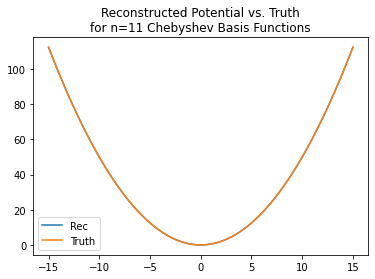

l2 error of vtruerec:
2.0507092951114852e-12
l-infinity error of vtruerec:
3.410605131648481e-13


In [35]:
###############################################################
# function for computing Chebyshev coefficients
# for a given function
###############################################################

def fntocheb(fn):
    chebweights = np.ones(numcheb + 1)
    chebweights[0] = 0.5

    def theta(k):
        return (k - 0.5) * np.pi / (numcheb + 1)

    def g(k):
        return fn(L * np.cos(theta(k)))

    chebvec = 2 * np.sum(g(kvec) * np.cos(chebnvec[..., np.newaxis] * theta(kvec)), axis=1) / (numcheb + 1)

    chebvec = chebweights * chebvec

    return chebvec


vtruecheb = fntocheb(v)
print(vtruecheb)

vtruerec = chebtox @ vtruecheb

# plot reconstructed potential vs truth
plt.plot(xvec, vtruerec, label='Rec')
plt.plot(xvec, vtruexvec, label='Truth')
plt.title(f'Reconstructed Potential vs. Truth\nfor n={numcheb} Chebyshev Basis Functions')
plt.legend()
plt.show()

# vec L2 error
print('l2 error of vtruerec:', nl.norm(vtruexvec - vtruerec), sep='\n')
# L-infinity error
print('l-infinity error of vtruerec:', np.max(np.abs(vtruexvec - vtruerec)), sep='\n')

In [36]:
def chebwaveobject(theta):
    #################################################
    # theta is a vector containing the Chebyshev
    # coefficients (i.e., the Chebyshev representation
    # of the potential)
    #################################################

    # construct the vmat from theta
    vhatmat = chebtofour @ theta

    # Construct Hamiltonian matrix
    hhatmat = kmat + vhatmat

    # eigen-decomposition of the Hamiltonian matrix
    spchat, stthat = jnl.eigh(hhatmat)

    # compute propagator matrix
    propahat = stthat @ jnp.diag(jnp.exp(-1j * spchat * dt)) @ stthat.conj().T

    # forward propagation loop
    ahatmatvec = []
    for r in range(a0vec.shape[0]):
        thisahatmat = [a0vec[r].copy()]

        # propagate system starting from initial "a" state
        for _ in range(numts):
            # propagate the system one time-step
            thisahatmat.append(propahat @ thisahatmat[-1])

        ahatmatvec.append(thisahatmat)

    # transform python list to a jax.numpy array
    ahatmatvec = jnp.array(ahatmatvec)

    # compute objective functions
    resid = ahatmatvec - amattruevec

    # as per our math, we need to take the real part of
    # the objective
    rtnobjvec = jnp.real(0.5 * jnp.sum(jnp.conj(resid) * resid, axis=1))
    rtnobj = jnp.sum(rtnobjvec)

    return rtnobj


# jit wavefnobject()
jitchebwaveobject = jax.jit(chebwaveobject)

# precompile jitwavefnobject with Chebyshev representation
# of the true potential
print('jitchebwaveobject(vtruecheb) =', jitchebwaveobject(vtruecheb))

jitchebwaveobject(vtruecheb) = 1.0050021217981043e-26


In [19]:
jitchebwavegradsjax = jax.jit(jax.grad(chebwaveobject))

# precompile chebwavegradsjax with Chebyshev representation
# of the true potential
print('nl.norm(jitchebwavegradsjax(vtruecheb)) =', nl.norm(jitchebwavegradsjax(vtruecheb)))

nl.norm(jitchebwavegradsjax(vtruecheb)) = 9.867913691728284e-15


---
**Adjoint Method**

In [23]:
###############################################################
# adjoint method for computing gradient
###############################################################

# function for computing gradients using adjoint method
def chebwavegradsadj(theta):
    #################################################
    # theta is a vector containing the Chebyshev
    # coefficients (i.e., the Chebyshev representation
    # of the potential)
    #################################################

    # construct the vmat from theta
    vhatmat = chebtofour @ theta

    # Construct Hamiltonian matrix
    hhatmat = kmat + vhatmat

    # eigen-decomposition of the Hamiltonian matrix
    spchat, stthat = jnl.eigh(hhatmat)

    # compute propagator matrices
    propahat = stthat @ jnp.diag(jnp.exp(-1j * spchat * dt)) @ stthat.conj().T
    proplam = jnp.transpose(jnp.conjugate(propahat))

    # forward propagation
    ahatmatvec = []
    lammatvec = []
    for r in range(a0vec.shape[0]):
        ####################################################
        # build ahatmat, i.e., forward propagate of the
        # system with theta starting from a given initial
        # state a0
        ####################################################

        # initialize thisahatmat with given a0 state
        thisahatmat = [a0vec[r].copy()]

        # forward propagate of the system with theta
        for i in range(numts):
            # propagate the system one time-step and store the result
            thisahatmat.append(propahat @ thisahatmat[-1])

        # store compute ahatmat
        ahatmatvec.append(jnp.array(thisahatmat))

        ####################################################
        # build lammat
        # \lambda_N = (\hat{a}_N - a_N)
        # \lambda_j = (\hat{a}_j - a_j) + [\nabla_a \phi_{\Delta t} (a_j; \theta)]^\dagger \lambda_{j+1}
        # [\nabla_a \phi_{\Delta t} (a_j; \theta)]^\dagger = [exp{-i H \Delta t}]^\dagger
        ####################################################

        # compute the error of ahatmatvec[r] WRT amattruevec[r]
        thisahatmaterr = ahatmatvec[r] - amattruevec[r]

        # initialize thislammat
        thislammat = [thisahatmaterr[-1]]

        # build lammat backwards then flip
        for i in range(2, numts + 2):
            thislammat.append(thisahatmaterr[-i] + proplam @ thislammat[-1])

        # flip thislammat, make into a jax array, and add to lammatvec
        lammatvec.append(jnp.flipud(jnp.array(thislammat)))

    # make lists into JAX array object
    ahatmatvec = jnp.array(ahatmatvec)
    lammatvec = jnp.array(lammatvec)


    ####################################################
    # the remainder of this function is for computing
    # the gradient of the exponential matrix
    ####################################################

    offdiagmask = jnp.ones((numtoepelms, numtoepelms)) - jnp.eye(numtoepelms)
    expspec = jnp.exp(-1j * dt * spchat)
    e1, e2 = jnp.meshgrid(expspec, expspec)
    s1, s2 = jnp.meshgrid(spchat, spchat)
    denom = offdiagmask * (-1j * dt) * (s1 - s2) + jnp.eye(numtoepelms)
    mask = offdiagmask * (e1 - e2)/denom + jnp.diag(expspec)

    derivamat = jnp.einsum('ij,jkm,kl->ilm', jnp.transpose(jnp.conj(stthat)), chebtofour, stthat) * jnp.expand_dims(mask, 2)

    # because the Chebyshev coefficients are real valued
    # alldmat is half the size it would be if the coefficients
    # were complex (like with the Fourier basis)
    alldmat = -1j * dt * jnp.einsum('ij,jkm,kl->mil', stthat, derivamat, stthat.conj().T)

    # compute all entries of the gradient at once
    gradients = jnp.real(jnp.einsum('bij,ajk,bik->a', jnp.conj(lammatvec[:, 1:]), alldmat, ahatmatvec[:, :-1]))

    return gradients


# jist adjgrads
jitchebwavegradsadj = jax.jit(chebwavegradsadj)

# precompile chebwavegradsjax with Chebyshev representation
# of the true potential
print('nl.norm(jitchebwavegradsadj(vtruecheb)) =', nl.norm(jitchebwavegradsadj(vtruecheb)))

nl.norm(jitchebwavegradsadj(vtruecheb)) = 1.550047724435227e-14


In [37]:
###############################################################
# Evaluate adjoint gradient
# - generate a theta of random values
# - compute the adjoint and JAX gradients
# - compute the error of the adjoint gradient WRT the JAX
#   gradient
###############################################################

# number of iterations
numitr = 100

# evaluate the gradients
totalerr = 0
for i in range(numitr):
    # generate a theta with random values
    # thisthetarnd = np.random.default_rng().normal(size=numcheb + 1) * 10
    thisthetarnd = 10.0 * np.random.default_rng().uniform(size=numcheb + 1) - 5.0

    # compute the gradient
    t1 = time.time()
    adjgrad = jitchebwavegradsadj(thisthetarnd)
    t2 = time.time()
    jaxgrad = jitchebwavegradsjax(thisthetarnd)
    t3 = time.time()

    # results
    print("adj time =", t2 - t1)
    print("jax time =", t3 - t2)
    thiserr = nl.norm(adjgrad - jaxgrad)
    totalerr += thiserr
    print("error =", thiserr)

print('Mean error:', totalerr/numitr)

adj time = 0.02460622787475586
jax time = 0.005448341369628906
error = 1.3676487714281337e-14
adj time = 0.004107236862182617
jax time = 0.00561976432800293
error = 2.4855401755575022e-14
adj time = 0.003968000411987305
jax time = 0.005547285079956055
error = 2.3704659063533806e-14
adj time = 0.005702972412109375
jax time = 0.0067119598388671875
error = 9.368458738146761e-14
adj time = 0.005527973175048828
jax time = 0.005822658538818359
error = 1.7460932027049042e-14
adj time = 0.004413127899169922
jax time = 0.006213188171386719
error = 2.998809804759879e-14
adj time = 0.009348869323730469
jax time = 0.0051305294036865234
error = 2.8241919613718534e-14
adj time = 0.005702018737792969
jax time = 0.006090641021728516
error = 3.2394919366362036e-14
adj time = 0.004569530487060547
jax time = 0.005963563919067383
error = 4.1373577197774325e-14
adj time = 0.005418539047241211
jax time = 0.00491023063659668
error = 3.062798608084815e-14
adj time = 0.003998756408691406
jax time = 0.005533695

---

In [26]:
seed = 1234  # set to None for random initialization
thetarnd = 10.0 * np.random.default_rng(seed).uniform(size=numcheb + 1) - 5.0

In [27]:
thetahat = so.minimize(fun=jitchebwaveobject, x0=thetarnd, jac=jitchebwavegradsadj, tol=1e-12, options={'maxiter': 4000, 'disp': True, 'gtol': 1e-15}).x

         Current function value: 0.000000
         Iterations: 185
         Function evaluations: 226
         Gradient evaluations: 217


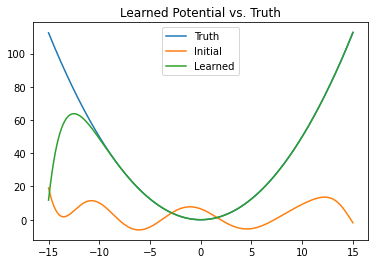

In [28]:
# plot learned vs true
plt.plot(xvec, vtruexvec, label='Truth')
plt.plot(xvec, chebtox @ thetarnd, label='Initial')
plt.plot(xvec, chebtox @ thetahat, label='Learned')
plt.title('Learned Potential vs. Truth')
plt.legend()
plt.show()